In [ ]:
import torch
torch.cuda.empty_cache()

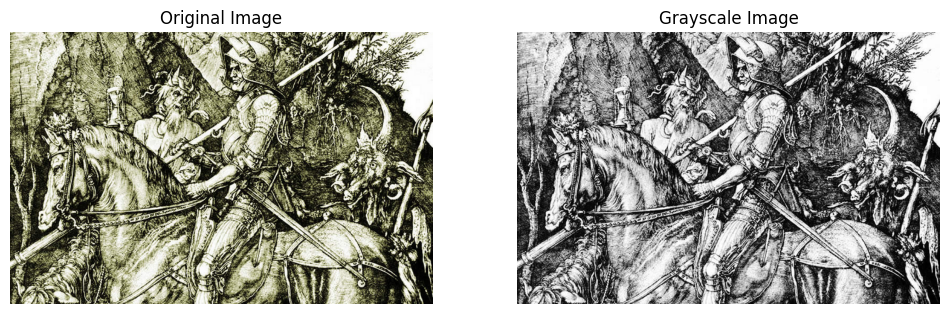

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_image_as_tensor(image_path):
    """Load an image and convert it to a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    return transform(image)

def show_images(original_tensor, grayscale_tensor):
    """Display the original and grayscale images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_tensor.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(grayscale_tensor.squeeze(), cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')

    plt.show()

def process_directory(directory_path, output_directory_base):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.png'):
                original_image_path = os.path.join(root, file)

                # Assuming grayscale images are saved in a mirrored directory structure
                relative_path = os.path.relpath(root, directory_path)
                grayscale_image_path = os.path.join(output_directory_base, relative_path, file)

                if os.path.exists(grayscale_image_path):  # Check if the grayscale image exists
                    # Load images as PyTorch tensors
                    original_tensor = load_image_as_tensor(original_image_path)
                    grayscale_tensor = load_image_as_tensor(grayscale_image_path)

                    # Show the images
                    show_images(original_tensor, grayscale_tensor)

                return  # Process only one image per directory

# Define the paths
directory_path = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\training_set'  # Update this path
output_directory_base = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\gray_training_set'  # Update this path

# Process one image from each directory
process_directory(directory_path, output_directory_base)

In [ ]:
from torchvision import transforms

# Transform for grayscale images (input)
transform_grayscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transform for color images (target)
transform_color = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_grayscale=None, transform_color=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform_grayscale: Transforms for grayscale images.
        transform_color: Transforms for color images.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform_grayscale)
        self.color_dataset = ImageFolder(color_dir, transform=transform_color)

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\gray_training_set',
    color_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\training_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\gray_validation_set',
    color_dir=r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\dataset\validation_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform: PyTorch transforms for transforms and tensor conversion.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform)
        self.color_dataset = ImageFolder(color_dir, transform=transform)
        self.transform = transform

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [ ]:
for inputs, _ in DataLoader(training_data, batch_size=1, shuffle=True):
    print(f"Grayscale image size: {inputs.size()}")
    break  # Print the size of the first batch only to check the dimensions.

Grayscale image size: torch.Size([1, 1, 256, 256])


In [ ]:
import torch
import torch.nn as nn

class ModifiedBottleneck(nn.Module):
    expansion = 2  # Lowered from the original 4 to reduce complexity

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ModifiedBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ColorizationResNet(nn.Module):
    def __init__(self):
        super(ColorizationResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ResNet layers with modified bottleneck
        self.layer1 = self._make_layer(ModifiedBottleneck, 64, 3, stride=1)
        self.layer2 = self._make_layer(ModifiedBottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(ModifiedBottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(ModifiedBottleneck, 512, 3, stride=2)

        # Upsampling layers
        self.upsample_layers = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.final_activation = nn.Tanh()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.upsample_layers(x)
        x = self.final_conv(x)
        x = self.final_activation(x)
        x = (x + 1) / 2  # Normalize output to [0, 1]
        return x


In [ ]:
print("Output size:", outputs.size())
print("Target size:", targets.size())
print("Input size:", inputs.size())

NameError: name 'outputs' is not defined

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

RESNET_model = ColorizationResNet().cuda()  # Initialize the ResNet model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(RESNET_model.parameters(), lr=0.0001)  # Initial lr=0.0001

num_epochs = 70  # Total epochs: 50 with lr=0.0001, 20 with lr=0.00001, 20 with lr=0.000001
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    # Update the learning rate according to the schedule
    if epoch == 50:  # After 50 epochs, change the LR to 0.00001
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001
        print("Learning rate changed to 0.00001.")
    elif epoch == 65:  # After 65 epochs, change the LR to 0.000001
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.000001
        print("Learning rate changed to 0.000001.")

    RESNET_model.train()  # Set the ResNet model to training mode
    train_loss = 0.0
    train_loader = tqdm(training_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = RESNET_model(inputs)  # Use the ResNet model for prediction
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loader.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(training_loader)
    training_losses.append(avg_train_loss)
    print(f'\nEpoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')

    RESNET_model.eval()  # Set the ResNet model to evaluation mode
    validation_loss = 0.0
    validation_loader_tqdm = tqdm(validation_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    with torch.no_grad():
        for inputs, targets in validation_loader_tqdm:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = RESNET_model(inputs)  # Use the ResNet model for prediction
            loss = criterion(outputs, targets)
            validation_loss += loss.item()
            validation_loader_tqdm.set_postfix(loss=loss.item())

    avg_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(avg_validation_loss)
    print(f'\nEpoch {epoch+1}, Validation Loss: {avg_validation_loss:.4f}')

Epoch 1/70 [Training]:  66%|████████████████████████████▉               | 318/483 [02:33<00:59,  2.78it/s, loss=0.0155]C:\Users\Zhengqi Wang\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [03:48<00:00,  2.11it/s, loss=0.0138]



Epoch 1, Training Loss: 0.0196


Epoch 1/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:10<00:00,  5.13it/s, loss=0.00817]



Epoch 1, Validation Loss: 0.0108


Epoch 2/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:54<00:00,  2.06it/s, loss=0.00804]



Epoch 2, Training Loss: 0.0111


Epoch 2/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:12<00:00,  4.26it/s, loss=0.00747]



Epoch 2, Validation Loss: 0.0089


Epoch 3/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [04:01<00:00,  2.00it/s, loss=0.00885]



Epoch 3, Training Loss: 0.0095


Epoch 3/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:13<00:00,  3.97it/s, loss=0.00813]



Epoch 3, Validation Loss: 0.0084


Epoch 4/70 [Training]: 100%|████████████████████████████████████████████| 483/483 [04:11<00:00,  1.92it/s, loss=0.0082]



Epoch 4, Training Loss: 0.0089


Epoch 4/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.98it/s, loss=0.00934]



Epoch 4, Validation Loss: 0.0124


Epoch 5/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00781]



Epoch 5, Training Loss: 0.0086


Epoch 5/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:14<00:00,  3.78it/s, loss=0.00707]



Epoch 5, Validation Loss: 0.0083


Epoch 6/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:44<00:00,  2.15it/s, loss=0.00691]



Epoch 6, Training Loss: 0.0083


Epoch 6/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.62it/s, loss=0.00599]



Epoch 6, Validation Loss: 0.0073


Epoch 7/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:36<00:00,  2.24it/s, loss=0.00717]



Epoch 7, Training Loss: 0.0080


Epoch 7/70 [Validation]: 100%|████████████████████████████████████████████| 54/54 [00:09<00:00,  5.55it/s, loss=0.0061]



Epoch 7, Validation Loss: 0.0074


Epoch 8/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:40<00:00,  2.19it/s, loss=0.00539]



Epoch 8, Training Loss: 0.0076


Epoch 8/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.67it/s, loss=0.00533]



Epoch 8, Validation Loss: 0.0069


Epoch 9/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [05:02<00:00,  1.59it/s, loss=0.00808]



Epoch 9, Training Loss: 0.0071


Epoch 9/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:11<00:00,  4.70it/s, loss=0.00484]



Epoch 9, Validation Loss: 0.0067


Epoch 10/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:16<00:00,  1.53it/s, loss=0.00877]



Epoch 10, Training Loss: 0.0068


Epoch 10/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:14<00:00,  3.65it/s, loss=0.00484]



Epoch 10, Validation Loss: 0.0067


Epoch 11/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:27<00:00,  1.47it/s, loss=0.00508]



Epoch 11, Training Loss: 0.0065


Epoch 11/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:11<00:00,  4.87it/s, loss=0.00492]



Epoch 11, Validation Loss: 0.0064


Epoch 12/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:07<00:00,  1.57it/s, loss=0.00423]



Epoch 12, Training Loss: 0.0062


Epoch 12/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:13<00:00,  4.00it/s, loss=0.00678]



Epoch 12, Validation Loss: 0.0066


Epoch 13/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [04:44<00:00,  1.70it/s, loss=0.00698]



Epoch 13, Training Loss: 0.0058


Epoch 13/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:11<00:00,  4.53it/s, loss=0.00653]



Epoch 13, Validation Loss: 0.0066


Epoch 14/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:05<00:00,  1.58it/s, loss=0.00532]



Epoch 14, Training Loss: 0.0056


Epoch 14/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:12<00:00,  4.19it/s, loss=0.0056]



Epoch 14, Validation Loss: 0.0070


Epoch 15/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [04:14<00:00,  1.90it/s, loss=0.0039]



Epoch 15, Training Loss: 0.0053


Epoch 15/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.45it/s, loss=0.0034]



Epoch 15, Validation Loss: 0.0066


Epoch 16/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:56<00:00,  2.05it/s, loss=0.00459]



Epoch 16, Training Loss: 0.0050


Epoch 16/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.63it/s, loss=0.0043]



Epoch 16, Validation Loss: 0.0066


Epoch 17/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:13<00:00,  2.50it/s, loss=0.00485]



Epoch 17, Training Loss: 0.0047


Epoch 17/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.45it/s, loss=0.00907]



Epoch 17, Validation Loss: 0.0068


Epoch 18/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:34<00:00,  2.25it/s, loss=0.00428]



Epoch 18, Training Loss: 0.0047


Epoch 18/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:09<00:00,  5.73it/s, loss=0.0068]



Epoch 18, Validation Loss: 0.0062


Epoch 19/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:42<00:00,  2.17it/s, loss=0.00513]



Epoch 19, Training Loss: 0.0043


Epoch 19/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:11<00:00,  4.55it/s, loss=0.0118]



Epoch 19, Validation Loss: 0.0063


Epoch 20/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:36<00:00,  2.23it/s, loss=0.00294]



Epoch 20, Training Loss: 0.0042


Epoch 20/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.77it/s, loss=0.00455]



Epoch 20, Validation Loss: 0.0061


Epoch 21/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:33<00:00,  2.26it/s, loss=0.00319]



Epoch 21, Training Loss: 0.0042


Epoch 21/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.76it/s, loss=0.00622]



Epoch 21, Validation Loss: 0.0063


Epoch 22/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:42<00:00,  2.17it/s, loss=0.00454]



Epoch 22, Training Loss: 0.0040


Epoch 22/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.55it/s, loss=0.00428]



Epoch 22, Validation Loss: 0.0061


Epoch 23/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:41<00:00,  2.18it/s, loss=0.00347]



Epoch 23, Training Loss: 0.0039


Epoch 23/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:10<00:00,  5.05it/s, loss=0.00518]



Epoch 23, Validation Loss: 0.0059


Epoch 24/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [04:01<00:00,  2.00it/s, loss=0.0069]



Epoch 24, Training Loss: 0.0038


Epoch 24/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:13<00:00,  4.12it/s, loss=0.00643]



Epoch 24, Validation Loss: 0.0067


Epoch 25/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [04:05<00:00,  1.97it/s, loss=0.00289]



Epoch 25, Training Loss: 0.0038


Epoch 25/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:10<00:00,  5.34it/s, loss=0.00563]



Epoch 25, Validation Loss: 0.0060


Epoch 26/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:04<00:00,  1.32it/s, loss=0.00512]



Epoch 26, Training Loss: 0.0036


Epoch 26/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:22<00:00,  2.44it/s, loss=0.00509]



Epoch 26, Validation Loss: 0.0060


Epoch 27/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:59<00:00,  1.15it/s, loss=0.00265]



Epoch 27, Training Loss: 0.0035


Epoch 27/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:14<00:00,  3.82it/s, loss=0.00499]



Epoch 27, Validation Loss: 0.0058


Epoch 28/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:31<00:00,  1.46it/s, loss=0.00532]



Epoch 28, Training Loss: 0.0034


Epoch 28/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:14<00:00,  3.64it/s, loss=0.00519]



Epoch 28, Validation Loss: 0.0064


Epoch 29/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:03<00:00,  1.33it/s, loss=0.00365]



Epoch 29, Training Loss: 0.0034


Epoch 29/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:19<00:00,  2.73it/s, loss=0.0034]



Epoch 29, Validation Loss: 0.0057


Epoch 30/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:51<00:00,  1.37it/s, loss=0.00313]



Epoch 30, Training Loss: 0.0033


Epoch 30/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:16<00:00,  3.23it/s, loss=0.00648]



Epoch 30, Validation Loss: 0.0057


Epoch 31/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:14<00:00,  1.29it/s, loss=0.00313]



Epoch 31, Training Loss: 0.0033


Epoch 31/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:15<00:00,  3.38it/s, loss=0.00595]



Epoch 31, Validation Loss: 0.0056


Epoch 32/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:37<00:00,  1.21it/s, loss=0.00518]



Epoch 32, Training Loss: 0.0033


Epoch 32/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:12<00:00,  4.29it/s, loss=0.00879]



Epoch 32, Validation Loss: 0.0057


Epoch 33/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:40<00:00,  1.21it/s, loss=0.00326]



Epoch 33, Training Loss: 0.0031


Epoch 33/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:16<00:00,  3.20it/s, loss=0.00673]



Epoch 33, Validation Loss: 0.0057


Epoch 34/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [04:53<00:00,  1.65it/s, loss=0.00284]



Epoch 34, Training Loss: 0.0031


Epoch 34/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:10<00:00,  4.97it/s, loss=0.00649]



Epoch 34, Validation Loss: 0.0061


Epoch 35/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [04:46<00:00,  1.69it/s, loss=0.00541]



Epoch 35, Training Loss: 0.0031


Epoch 35/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:17<00:00,  3.13it/s, loss=0.00558]



Epoch 35, Validation Loss: 0.0056


Epoch 36/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:28<00:00,  1.24it/s, loss=0.00291]



Epoch 36, Training Loss: 0.0030


Epoch 36/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:48<00:00,  1.11it/s, loss=0.00727]



Epoch 36, Validation Loss: 0.0059


Epoch 37/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [07:54<00:00,  1.02it/s, loss=0.00267]



Epoch 37, Training Loss: 0.0030


Epoch 37/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:17<00:00,  3.16it/s, loss=0.00312]



Epoch 37, Validation Loss: 0.0060


Epoch 38/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [07:29<00:00,  1.07it/s, loss=0.00178]



Epoch 38, Training Loss: 0.0029


Epoch 38/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:23<00:00,  2.29it/s, loss=0.0044]



Epoch 38, Validation Loss: 0.0056


Epoch 39/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [07:10<00:00,  1.12it/s, loss=0.00166]



Epoch 39, Training Loss: 0.0028


Epoch 39/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:19<00:00,  2.84it/s, loss=0.00735]



Epoch 39, Validation Loss: 0.0056


Epoch 40/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:43<00:00,  1.20it/s, loss=0.00351]



Epoch 40, Training Loss: 0.0028


Epoch 40/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:13<00:00,  3.98it/s, loss=0.00794]



Epoch 40, Validation Loss: 0.0055


Epoch 41/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [06:15<00:00,  1.28it/s, loss=0.00221]



Epoch 41, Training Loss: 0.0027


Epoch 41/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:12<00:00,  4.18it/s, loss=0.00415]



Epoch 41, Validation Loss: 0.0054


Epoch 42/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:43<00:00,  1.41it/s, loss=0.00201]



Epoch 42, Training Loss: 0.0028


Epoch 42/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:13<00:00,  4.13it/s, loss=0.00398]



Epoch 42, Validation Loss: 0.0055


Epoch 43/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [05:57<00:00,  1.35it/s, loss=0.00358]



Epoch 43, Training Loss: 0.0027


Epoch 43/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:10<00:00,  4.91it/s, loss=0.00796]



Epoch 43, Validation Loss: 0.0056


Epoch 44/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:02<00:00,  2.64it/s, loss=0.00211]



Epoch 44, Training Loss: 0.0027


Epoch 44/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.42it/s, loss=0.00448]



Epoch 44, Validation Loss: 0.0056


Epoch 45/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [02:51<00:00,  2.82it/s, loss=0.00251]



Epoch 45, Training Loss: 0.0027


Epoch 45/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.51it/s, loss=0.00402]



Epoch 45, Validation Loss: 0.0056


Epoch 46/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [02:57<00:00,  2.72it/s, loss=0.00332]



Epoch 46, Training Loss: 0.0026


Epoch 46/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:08<00:00,  6.51it/s, loss=0.0067]



Epoch 46, Validation Loss: 0.0055


Epoch 47/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:16<00:00,  2.46it/s, loss=0.00192]



Epoch 47, Training Loss: 0.0025


Epoch 47/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.87it/s, loss=0.00368]



Epoch 47, Validation Loss: 0.0056


Epoch 48/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:04<00:00,  2.62it/s, loss=0.00476]



Epoch 48, Training Loss: 0.0025


Epoch 48/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.34it/s, loss=0.00924]



Epoch 48, Validation Loss: 0.0058


Epoch 49/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:03<00:00,  2.63it/s, loss=0.00221]



Epoch 49, Training Loss: 0.0025


Epoch 49/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.30it/s, loss=0.00625]



Epoch 49, Validation Loss: 0.0055


Epoch 50/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [02:57<00:00,  2.73it/s, loss=0.00275]



Epoch 50, Training Loss: 0.0024


Epoch 50/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.38it/s, loss=0.00839]



Epoch 50, Validation Loss: 0.0057
Learning rate changed to 0.00001.


Epoch 51/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:04<00:00,  2.62it/s, loss=0.00293]



Epoch 51, Training Loss: 0.0022


Epoch 51/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.81it/s, loss=0.00519]



Epoch 51, Validation Loss: 0.0052


Epoch 52/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:07<00:00,  2.57it/s, loss=0.00339]



Epoch 52, Training Loss: 0.0021


Epoch 52/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.23it/s, loss=0.00472]



Epoch 52, Validation Loss: 0.0052


Epoch 53/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:03<00:00,  2.63it/s, loss=0.00176]



Epoch 53, Training Loss: 0.0021


Epoch 53/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.36it/s, loss=0.00646]



Epoch 53, Validation Loss: 0.0052


Epoch 54/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [02:59<00:00,  2.69it/s, loss=0.00175]



Epoch 54, Training Loss: 0.0020


Epoch 54/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.09it/s, loss=0.00504]



Epoch 54, Validation Loss: 0.0052


Epoch 55/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:03<00:00,  2.64it/s, loss=0.00151]



Epoch 55, Training Loss: 0.0020


Epoch 55/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.08it/s, loss=0.00349]



Epoch 55, Validation Loss: 0.0052


Epoch 56/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:15<00:00,  2.47it/s, loss=0.00266]



Epoch 56, Training Loss: 0.0020


Epoch 56/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.14it/s, loss=0.00434]



Epoch 56, Validation Loss: 0.0052


Epoch 57/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:14<00:00,  2.48it/s, loss=0.00189]



Epoch 57, Training Loss: 0.0020


Epoch 57/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.02it/s, loss=0.00592]



Epoch 57, Validation Loss: 0.0052


Epoch 58/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [02:55<00:00,  2.75it/s, loss=0.0016]



Epoch 58, Training Loss: 0.0020


Epoch 58/70 [Validation]: 100%|███████████████████████████████████████████| 54/54 [00:08<00:00,  6.38it/s, loss=0.0048]



Epoch 58, Validation Loss: 0.0053


Epoch 59/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:03<00:00,  2.63it/s, loss=0.00271]



Epoch 59, Training Loss: 0.0020


Epoch 59/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.41it/s, loss=0.00425]



Epoch 59, Validation Loss: 0.0052


Epoch 60/70 [Training]: 100%|███████████████████████████████████████████| 483/483 [03:04<00:00,  2.62it/s, loss=0.0028]



Epoch 60, Training Loss: 0.0019


Epoch 60/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.05it/s, loss=0.00611]



Epoch 60, Validation Loss: 0.0052


Epoch 61/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:02<00:00,  2.65it/s, loss=0.00287]



Epoch 61, Training Loss: 0.0019


Epoch 61/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.44it/s, loss=0.00606]



Epoch 61, Validation Loss: 0.0053


Epoch 62/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:02<00:00,  2.64it/s, loss=0.00177]



Epoch 62, Training Loss: 0.0019


Epoch 62/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.24it/s, loss=0.00754]



Epoch 62, Validation Loss: 0.0052


Epoch 63/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:03<00:00,  2.63it/s, loss=0.00273]



Epoch 63, Training Loss: 0.0019


Epoch 63/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.38it/s, loss=0.00464]



Epoch 63, Validation Loss: 0.0052


Epoch 64/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [02:59<00:00,  2.69it/s, loss=0.00244]



Epoch 64, Training Loss: 0.0019


Epoch 64/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.70it/s, loss=0.00471]



Epoch 64, Validation Loss: 0.0052


Epoch 65/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:09<00:00,  2.55it/s, loss=0.00169]



Epoch 65, Training Loss: 0.0019


Epoch 65/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.14it/s, loss=0.00306]



Epoch 65, Validation Loss: 0.0052
Learning rate changed to 0.000001.


Epoch 66/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:06<00:00,  2.59it/s, loss=0.00186]



Epoch 66, Training Loss: 0.0019


Epoch 66/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:09<00:00,  5.74it/s, loss=0.00698]



Epoch 66, Validation Loss: 0.0052


Epoch 67/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:06<00:00,  2.59it/s, loss=0.00233]



Epoch 67, Training Loss: 0.0019


Epoch 67/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.10it/s, loss=0.00338]



Epoch 67, Validation Loss: 0.0052


Epoch 68/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:10<00:00,  2.53it/s, loss=0.00288]



Epoch 68, Training Loss: 0.0019


Epoch 68/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.32it/s, loss=0.00557]



Epoch 68, Validation Loss: 0.0052


Epoch 69/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:03<00:00,  2.63it/s, loss=0.00151]



Epoch 69, Training Loss: 0.0019


Epoch 69/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.32it/s, loss=0.00364]



Epoch 69, Validation Loss: 0.0052


Epoch 70/70 [Training]: 100%|██████████████████████████████████████████| 483/483 [03:03<00:00,  2.63it/s, loss=0.00312]



Epoch 70, Training Loss: 0.0019


Epoch 70/70 [Validation]: 100%|██████████████████████████████████████████| 54/54 [00:08<00:00,  6.14it/s, loss=0.00616]


Epoch 70, Validation Loss: 0.0052


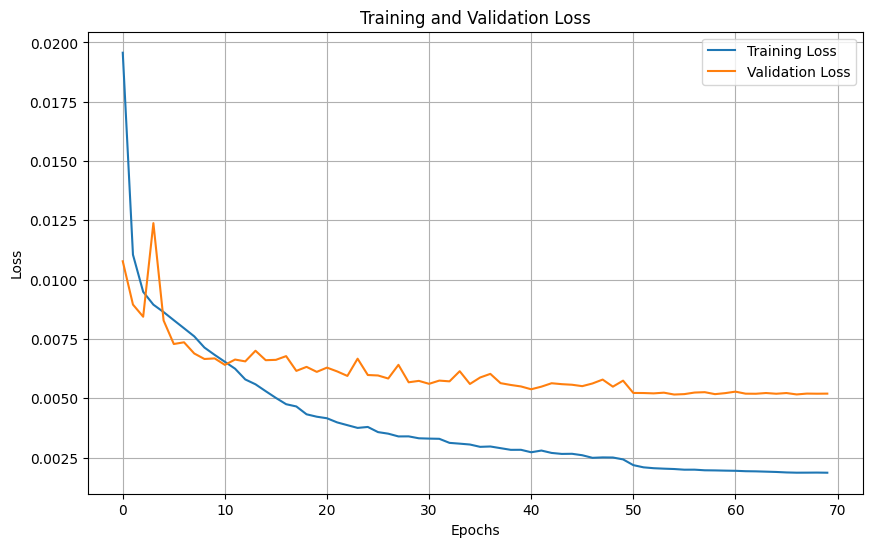

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

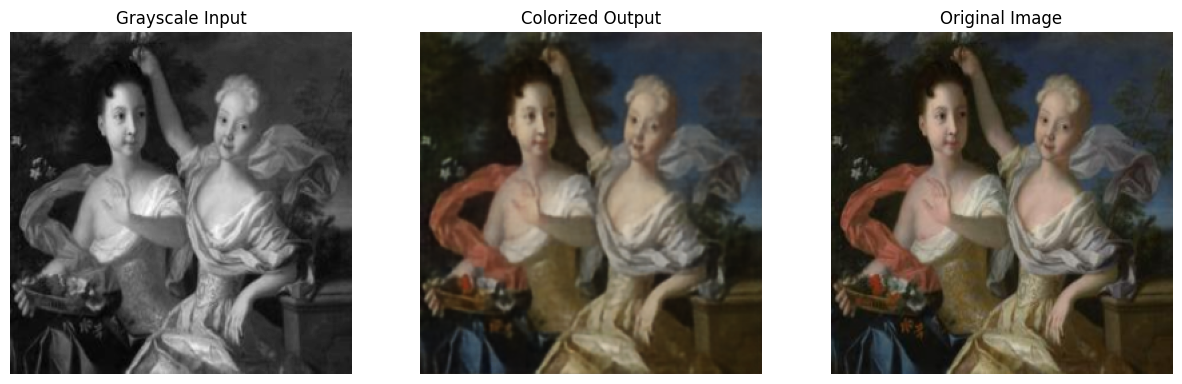

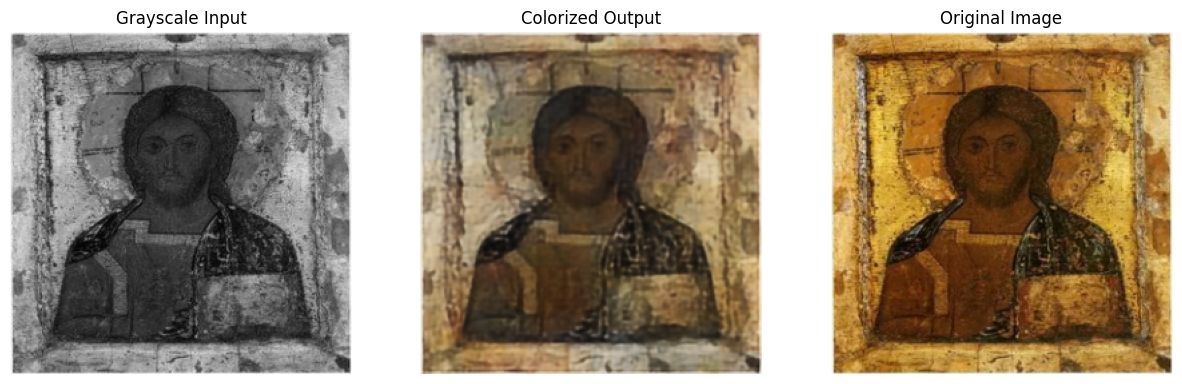

In [ ]:
def visualize_results(grayscale, colorized, original):
    """
    Visualize grayscale input, colorized output, and the original color image.
    """
    with torch.no_grad():
        # Convert to numpy arrays
        grayscale = grayscale.cpu().numpy().transpose((1, 2, 0))
        colorized = colorized.cpu().numpy().transpose((1, 2, 0))
        original = original.cpu().numpy().transpose((1, 2, 0))

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(grayscale, cmap='gray')
        ax[0].set_title("Grayscale Input")
        ax[0].axis("off")

        ax[1].imshow(colorized)
        ax[1].set_title("Colorized Output")
        ax[1].axis("off")

        ax[2].imshow(original)
        ax[2].set_title("Original Image")
        ax[2].axis("off")

        plt.show()

# Assuming `model`, `validation_loader` are already defined and ready to use
RESNET_model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = RESNET_model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[1], colorized_outputs[1], original_colors[1])
    visualize_results(grayscale_inputs[10], colorized_outputs[10], original_colors[10])

In [ ]:
model_path = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\resnet_loss=MSE_batch16_lr=0.0001_on50_&lr=0.00001on10&lr=0.0001on5\model_state_dict.pth'
torch.save(RESNET_model.state_dict(), model_path)

In [ ]:
import csv

# Specify the path to the CSV file where you want to save the losses
csv_file_path = model_path+'losses.csv'

# Open the file in write mode
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])

    # Write the losses for each epoch
    for epoch in range(num_epochs):
        writer.writerow([epoch + 1, training_losses[epoch], validation_losses[epoch]])

print(f"Losses saved to {csv_file_path}")

Losses saved to C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\resnet_loss=MSE_batch16_lr=0.0001_on50_&lr=0.00001on10&lr=0.0001on5\model_state_dict.pthlosses.csv


In [ ]:
model = ColorizationResNet().cuda()  # Or just ECCVGenerator() if not using CUDA

# Load the weights back
model.load_state_dict(torch.load(model_path))

# Don't forget to call model.eval() if you're in inference mode
model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[5], colorized_outputs[5], original_colors[5])